# Sources of Carbon

Before running this notebook, ensure /utils/Min-Mean-Max-Crustal-Carbon.ipynb has been run and crustal carbon grids have been produced.

#### Contents

1. [Carbon in the lithosphere](#Carbon-in-the-lithosphere)
2. [Carbon in serpentinite](#Carbon-in-serpentinite)
3. [Carbon in sediments](#Carbon-in-sediments)
4. [Carbon in the crust](#Carbon-in-the-crust)
5. [Carbon in organic sediments](#Carbon-in-organic-sediments)

In [1]:
import numpy as np
import gplately
from gplately.grids import write_netcdf_grid, read_netcdf_grid
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
from scipy.interpolate import RegularGridInterpolator
from scipy import ndimage
from joblib import Parallel, delayed
from IPython.display import clear_output
import os
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
%matplotlib inline
# plt.style.use('ggplot')

# common variables
extent_globe = [-180, 180, -90, 90]
earth_radius = 6371.009e3
earth_surface_area = 4.0*np.pi*earth_radius**2

# netCDF4 grid resolution
spacingX = 0.2
spacingY = 0.2
lon_grid = np.arange(extent_globe[0], extent_globe[1]+spacingX, spacingX)
lat_grid = np.arange(extent_globe[2], extent_globe[3]+spacingY, spacingY)

# reconstruction time steps and spacing
min_time = 0
max_time = 1000
timestep_size = 1
reconstruction_times = np.arange(min_time, max_time+timestep_size, timestep_size)

save_output_netcdf = True # !! important
DISABLE_GPLATELY_DEV_WARNING=True

### Define directories for saving outputs, and directories for input age and spreading rate grids

### Change `folder_name` to keep track of reruns of this notebook. The rest can be left as-is.

In [2]:
# Change `folder_name`: a string to name a new sub-folder for a new set of Notebook 1 outputs; 
# useful for keeping track of reruns
folder_name = "Muller22_Sep17"

# Don't change this: directory to input files
output_directory = "./Outputs/{}/Notebook01/".format(folder_name)
os.makedirs(output_directory, exist_ok=True)
os.makedirs(output_directory+"/figures", exist_ok=True)
os.makedirs(output_directory+"/csv", exist_ok=True)

# Don't change this: Ensure all needed output paths are created
output_carbon_grid_directory = "Reservoirs/{}/{}/"
for storage in ['Lithosphere', 'Serpentinite', 'Sediment', 'Crust', 'Organic_Sediments']:
    for quantity in ['min', 'mean', 'max']:
        path = os.path.join(output_directory, output_carbon_grid_directory.format(storage, quantity))
        os.makedirs(path, exist_ok=True)

# Change this: Directories to age grids and spreading rate grids
#grid_directory = input_directory+"SRGrids/"
grid_directory = "./Muller2022_InputGrids/"
spreadrate_filename = grid_directory+"SpreadingRate/Muller2022_SPREADING_RATE_grid_{:.2f}Ma.nc"
agegrid_filename = grid_directory+"SeafloorAge/Muller2022_SEAFLOOR_AGE_grid_{:.2f}Ma.nc"

In [3]:
cell_area = gplately.tools.lat_area_function(lat_grid, lat_grid+spacingY, lon_grid.size)
cell_area = np.tile(cell_area.reshape(-1,1), lon_grid.size)

## Carbon in the lithosphere

CO2 influx and outflux is related to the following parameters:

- $u$ Spreading rate
- $d$ Compaction length (fixed?)
- $T$ Temperature of the mantle
- $c$ Fertility of the mantle
- $v$ CO2 volatile content (elevated near hotspots)

These are fitted from a series of polynomial functions to get units of t/m/yr.

__Ridge outflux fit:__

$$
F = A + B_u (u - u_{\mathrm{ref}}) + B_d (d - d_{\mathrm{ref}}) + B_T (T - T_{\mathrm{ref}}) + B_c (c - c_{\mathrm{ref}}) + B_v (v - v_{\mathrm{ref}})
$$

__Plate influx fit:__

$$
F = A + B_u (u - u_{\mathrm{ref}}) + B_d (d - d_{\mathrm{ref}}) + B_T (T - T_{\mathrm{ref}}) + B_c (c - c_{\mathrm{ref}}) + B_v (v - v_{\mathrm{ref}}) + C_v (v^2 - v_{\mathrm{ref}}^2)
$$

We want to convert t/m/yr to t/m2

> __Citations:__
> * Keller, T., Katz, R. F., & Hirschmann, M. M. (2017). Volatiles beneath mid-ocean ridges: Deep melting, channelised transport, focusing, and metasomatism. Earth and Planetary Science Letters, 464, 55–68. https://doi.org/10.1016/j.epsl.2017.02.006
> * Le Voyer, M., Kelley, K. A., Cottrell, E. & Hauri, E. H. (2017) Heterogeneity in mantle carbon content from CO2-undersaturated basalts. Nat Commun 8: 14062.


### Required inputs:
Carbon in lithosphere requires spreading rate grids only.

In [4]:
u_ref = 3.0
d_ref = 1.504
T_ref = 1350.0
c_ref = 19.0
v_ref = 100.0 # ±54 ppm CO2 (Le Voyer et al. (2017))
delta_v_ref = 20.0 # ±54 ppm CO2 (Le Voyer et al. (2017))

def ridge_outflux(u, d, T, c, v):
    u = np.abs(u)
    A = 0.9919
    B_u = 0.3162
    B_d = -0.3739
    B_T = 0.0089
    B_c = 0.0294
    B_v = 0.0095
    return A + B_u*(u - u_ref) + B_d*(d - d_ref) + B_T*(T - T_ref) + B_c*(c - c_ref) + B_v*(v - v_ref)

def plate_influx(u, d, T, c, v):
    u = np.abs(u)
    A = 0.8807
    B_u = 0.262
    B_d = 0.3589
    B_T = -0.00029097
    B_c = 0.0075
    B_v = 0.0054
    C_v = 0.000035532
    F = A + B_u*(u - u_ref) + B_d*(d - d_ref) + B_T*(T - T_ref) + B_c*(c - c_ref) + B_v*(v - v_ref) + \
         C_v*(v**2 - v_ref**2)
    return F

print ("For a single sample spreading rate...")
print("Ridge outflux: ", ridge_outflux(u_ref, d_ref, T_ref, c_ref, 150.0))
print("Min plate influx: ", plate_influx(u_ref, d_ref, T_ref, c_ref, v_ref - delta_v_ref))
print("Mean plate influx: ", plate_influx(u_ref, d_ref, T_ref, c_ref, v_ref))
print("Max plate influx: ", plate_influx(u_ref, d_ref, T_ref, c_ref, v_ref + delta_v_ref))

For a single sample spreading rate...
Ridge outflux:  1.4668999999999999
Min plate influx:  0.6447848
Mean plate influx:  0.8807
Max plate influx:  1.1450408


In [5]:
# We now apply this polynomial to each node in the spreading rate grids:

######## PATH TO SAVE LITHOSPHERIC CARBON GRIDS TO. Do not change, only change parent_directory in cell 1. 
carbon_lithosphere_filename = output_directory+"Reservoirs/Lithosphere/{}/carbon_lithosphere_grid_{:04d}.nc"

def reconstruct_lithospheric_carbon(reconstruction_time):
    # mm/yr
    spreadrate_grid = read_netcdf_grid(spreadrate_filename.format(reconstruction_time),
                                       resample=(spacingX,spacingY))
    
    # t/m/yr
    v_min = v_ref - delta_v_ref
    v_mean = v_ref
    v_max = v_mean + delta_v_ref
    
    CO2_influx_grid_min  = plate_influx(0.5*spreadrate_grid/10, d_ref, T_ref, c_ref, v_min)
    CO2_influx_grid_mean = plate_influx(0.5*spreadrate_grid/10, d_ref, T_ref, c_ref, v_mean)
    CO2_influx_grid_max  = plate_influx(0.5*spreadrate_grid/10, d_ref, T_ref, c_ref, v_max)
    
    carbon_lithosphere = np.ma.array([CO2_influx_grid_min, CO2_influx_grid_mean, CO2_influx_grid_max])
    
    # unit conversions
    carbon_lithosphere /= spreadrate_grid*1e-3 # mm/yr to m/yr
    carbon_lithosphere *= 12.0107/44.0095 # convert CO2 t/m^2 to C t/m^2
    carbon_lithosphere *= 1e-6 # convert t/m^2 to Mt/m^2
    
    # Clip all minimum values that are below zero to 0
    carbon_lithosphere = np.clip(carbon_lithosphere, 0., None)
    
    # Mt C
    total_carbon_lithosphere = np.nansum(carbon_lithosphere*cell_area, axis=(1,2))
    
    if save_output_netcdf:
        write_netcdf_grid(carbon_lithosphere_filename.format("min", reconstruction_time), carbon_lithosphere[0])
        write_netcdf_grid(carbon_lithosphere_filename.format("mean",reconstruction_time), carbon_lithosphere[1])
        write_netcdf_grid(carbon_lithosphere_filename.format("max", reconstruction_time), carbon_lithosphere[2])
    
    return total_carbon_lithosphere

In [6]:
%env PYTHONWARNINGS=ignore::RuntimeWarning
        
total_carbon_lithosphere = Parallel(n_jobs=-3, verbose=1)(
    delayed(reconstruct_lithospheric_carbon)(t) for t in reconstruction_times)

env: PYTHONWARNINGS=ignore::RuntimeWarning


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-3)]: Done 184 tasks      | elapsed:  1.0min
/Users/lila0720/micromamba/envs/env_gplately/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-3)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-3)]: Done 784 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-3)]: Done 1001 out of 1001 | elapsed:  4.7min finished


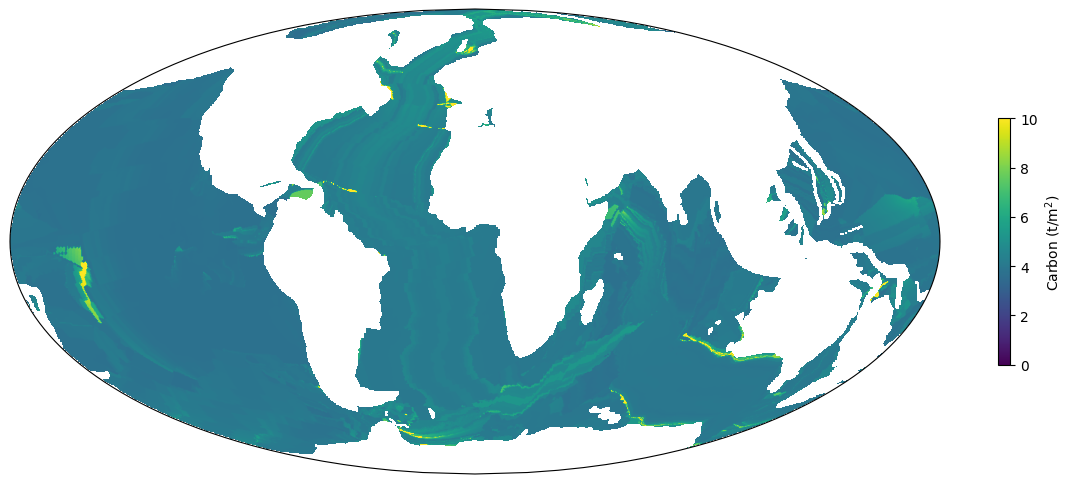

In [7]:
carbon_lithosphere_mean = read_netcdf_grid(carbon_lithosphere_filename.format("mean", 0))

proj = ccrs.Mollweide()

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=proj)
im = ax.imshow(carbon_lithosphere_mean*1e6, extent=extent_globe, origin='lower',
               transform=ccrs.PlateCarree(), vmin=0, vmax=10)
fig.colorbar(im, shrink=0.4, label='Carbon (t/m$^2$)')

## Carbon in serpentinite

> __Citation:__
> Merdith, A. S., Atkins, S. E., & Tetley, M. G. (2019). Tectonic Controls on Carbon and Serpentinite Storage in Subducted Upper Oceanic Lithosphere for the Past 320 Ma. Frontiers in Earth Science, 7(December), 1–23. https://doi.org/10.3389/feart.2019.00332

### Required inputs:
Carbon in serpentinite uses functions from scripts in the `/utils/` directory bundled in this workflow. These functions require spreading rate grids with valid masks.

In [8]:
import sys
sys.path.insert(0, os.path.abspath('./utils/'))

import utils.serpentinite_spreading_grids as serpentinite_spreading_grids
import utils.water_lithosphere_storage as water_lithosphere_storage

#uncertainty load in
with np.load(os.path.abspath("./utils/C_serp_array_individual.npz"), "r") as npz:
    C_serp_dist = npz['data']  
    
    
C_serp_stds = np.std(C_serp_dist, axis=1)
C_serp_stds = np.insert(C_serp_stds,0,0)


def carbon_serp_uncertainty(spreading_rate_array, nans_array, carbon_serpentinite_stds):
    ceil_SR = np.ceil(spreading_rate_array)
    ceil_SR_for_index = np.nan_to_num(ceil_SR, copy=False).astype(int)
    C_uncertainty = carbon_serpentinite_stds[ceil_SR_for_index]
    C_uncertainty[nans_array] = np.nan
    return C_uncertainty

In [9]:
######## PATH TO SAVE SERPENTINITE CARBON GRIDS TO. Do not change, only change parent_directory in cell 1. 
carbon_serpentinite_filename = output_directory+"Reservoirs/Serpentinite/{}/carbon_serpentinite_grid_{:04d}.nc"

def reconstruct_serpentinite_carbon(reconstruction_time):
    spreadrate_grid = read_netcdf_grid(spreadrate_filename.format(reconstruction_time),
                                       resample=(spacingX, spacingY))
    
    # interpolate within continents
    spreadrate_grid_filled = gplately.grids.fill_raster(spreadrate_grid)

    # This is a condensed version of Andrew's 'get_data' function
    samples = 10000
    nan_array = np.isnan(spreadrate_grid)

    # Partition peridotite magnitudes based on SR grid magnitude groups. Use uniform distribution.
    peridotite_percent_values = serpentinite_spreading_grids.SR_and_peridotite(
        samples, spreadrate_grid_filled, nan_array)

    # Take a spreading rate and return a thickness for slow or ultraslow spreading (less than 40 mm/a) 
    # and return a 'thickness' corresponding to the maximum depth of water penetration giving the maximum
    # depth of serpentinisation. i.e. this returns the depth to the unserpentinised mantle lithosphere
    thickness_values = serpentinite_spreading_grids.SR_and_thickness(
        samples, spreadrate_grid_filled, nan_array)

    # Grid nodes with lower spreading rate are grouped and mapped to groups of higher degrees of serpentinisation.
    # Using the maximum depths of serpentinisation, we obtain the degree of serpentinisation 
    # from ultraslow spreading.
    degree_of_serp_values = serpentinite_spreading_grids.degree_of_serpentinisation_of_system(
        spreadrate_grid_filled, thickness_values, nan_array)

    # Recover depths of serpentinisation
    serp_thickness = peridotite_percent_values/100 * thickness_values * degree_of_serp_values/100 * 1000.0/865

    # Get a grid of percentages, either 0.34% (mean from Kelemen and Manning 2015) for nodes with ultra-slow 
    # spreading (<=20 mm/yr), or 0.32% otherwise.
    carbonate_serp_thickness = serpentinite_spreading_grids.carbonate_content_serp(
        spreadrate_grid_filled, nan_array)

    # Carbonate serpentinite is obtained by partitioning serpentinite thickness based on carbonate percentages
    carbon_serpentinite_thickness_values = serp_thickness * carbonate_serp_thickness * 12.0/44

    # Calculate overall serpentinite uncertainties. C_serp_stds is data read from an external npz file.
    carb_serp_uncertainty = carbon_serp_uncertainty(spreadrate_grid_filled, nan_array, C_serp_stds)

    # unit conversions
    carbon_serpentinite = np.ma.array([carbon_serpentinite_thickness_values - carb_serp_uncertainty,
                                       carbon_serpentinite_thickness_values,
                                       carbon_serpentinite_thickness_values + carb_serp_uncertainty])
    
    # protect against negative carbon
    carbon_serpentinite[carbon_serpentinite < 0] = 0.0
    
    carbon_serpentinite *= 1000. # (I think this is in km to begin with)
    carbon_serpentinite *= 2600.0 # convert m to kg/m2 (multiply by density of serpentinite)
    carbon_serpentinite *= 1e-9 # convert kg/m2 to Mt/m2
    
    total_carbon_serpentinite = np.nansum(carbon_serpentinite*cell_area, axis=(1,2))
    
    if save_output_netcdf:
        write_netcdf_grid(carbon_serpentinite_filename.format("min", reconstruction_time), carbon_serpentinite[0])
        write_netcdf_grid(carbon_serpentinite_filename.format("mean",reconstruction_time), carbon_serpentinite[1])
        write_netcdf_grid(carbon_serpentinite_filename.format("max", reconstruction_time), carbon_serpentinite[2])
    
    return total_carbon_serpentinite

In [10]:
total_carbon_serpentinite = Parallel(n_jobs=-3, verbose=1)(
    delayed(reconstruct_serpentinite_carbon)(t) for t in reconstruction_times)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
/Users/lila0720/micromamba/envs/env_gplately/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-3)]: Done 184 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-3)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-3)]: Done 784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-3)]: Done 1001 out of 1001 | elapsed:  2.4min finished


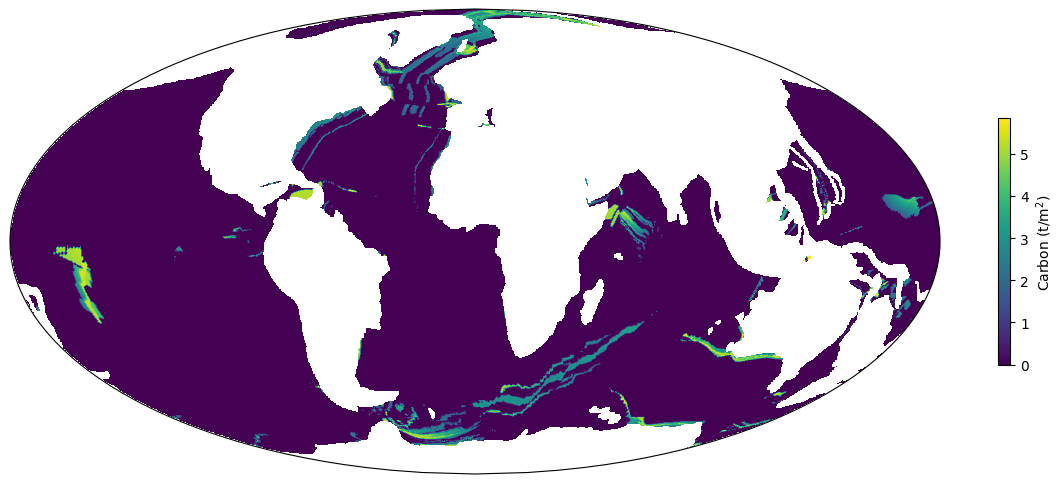

In [11]:
carbon_serpentinite_mean = read_netcdf_grid(carbon_serpentinite_filename.format("mean", 0))

proj = ccrs.Mollweide()

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=proj)
im = ax.imshow(carbon_serpentinite_mean*1e6, extent=extent_globe, origin='lower', transform=ccrs.PlateCarree())
fig.colorbar(im, shrink=0.4, label='Carbon (t/m$^2$)')

## Carbon in sediments

> __Citation:__
> Dutkiewicz, A., Müller, R. D., Cannon, J., Vaughan, S., & Zahirovic, S. (2019). Sequestration and subduction of deep-sea carbonate in the global ocean since the Early Cretaceous. Geology, 47(1), 91–94. https://doi.org/10.1130/G45424.1

Decompacted sediment thickness is composed of 70% carbonate which must be converted to t/m2 of carbon.


### Required inputs:
Carbon in sediments require:

* an **input carbonate sediment thickness grid per timestep** - typically use decompacted; for now, it is assumed that sediments contribute to total carbon from 170Ma to present day. We assume zero sediment contribution for 171Ma-1Ga, and thus sediment thickness grids for each of these timesteps are the corresponding continental masks.

In [12]:
######## An input CARBONATE sediment thickness grid
#sediments_filename = parent_directory+"Data/decompacted_carbonate_sediment_thickness/decompacted_carbonate_sediment_thickness_{}/decompacted_sediment_thickness_0.5_{}.nc"
sediments_filename = grid_directory+"CarbonateSediment/{}/Muller2022_decompacted_sediment_thickness_0.5_cobmasked_{:.1f}Ma.nc"


# Past 170 ma, we use empty grids because carbonate sediments are assumed to not exist. This is essentially
# a continental mask at 171Ma onwards.
continental_mask_filename = grid_directory+"ContinentalMasks/continent_mask_{:.1f}.nc"

####### PATH TO SAVE SEDIMENT CARBON GRIDS TO. Do not change, only change parent_directory in cell 1. 
carbon_sediments_filename = output_directory+"Reservoirs/Sediment/{}/carbon_sediment_grid_{:04d}.nc"

def reconstruct_sedimentary_carbon(reconstruction_time):
    
    save_time = reconstruction_time
    
    if reconstruction_time > 170:
        
        seds_grid_min = read_netcdf_grid(continental_mask_filename.format(reconstruction_time), resample=(spacingX, spacingY))
        seds_grid_min[seds_grid_min > 0.5] = np.nan
        seds_grid_mean = read_netcdf_grid(continental_mask_filename.format(reconstruction_time), resample=(spacingX, spacingY))
        seds_grid_mean[seds_grid_mean > 0.5] = np.nan
        seds_grid_max = read_netcdf_grid(continental_mask_filename.format(reconstruction_time), resample=(spacingX, spacingY))
        seds_grid_max[seds_grid_max > 0.5] = np.nan
        
        seds_grid = np.ma.array([seds_grid_min, seds_grid_mean, seds_grid_max])
        
    else:

        # decompacted sediment thickness (metres)
        seds_grid_min  = read_netcdf_grid(sediments_filename.format("Min", reconstruction_time), resample=(spacingX, spacingY))
        seds_grid_mean = read_netcdf_grid(sediments_filename.format("Mean",reconstruction_time), resample=(spacingX, spacingY))
        seds_grid_max  = read_netcdf_grid(sediments_filename.format("Max", reconstruction_time), resample=(spacingX, spacingY))
        seds_grid = np.ma.array([seds_grid_min, seds_grid_mean, seds_grid_max])

    # unit conversions
    seds_grid *= 0.7 # average carbonate in sediment is 70%
    seds_grid *= 0.41 # correct for pore space in coccolith ooze (Kominz et al. 2011)
    seds_grid *= 2710. # convert m to kg/m2 (multiply by density of coccolith ooze)
    seds_grid *= 12.0/100.1 # CaCO3 to C kg/m2
    seds_grid *= 1e-9 # kg/m2 to Mt/m2
    carbon_sediments = seds_grid

    total_carbon_sediments = np.nansum(carbon_sediments*cell_area, axis=(1,2))

    if save_output_netcdf:
        write_netcdf_grid(carbon_sediments_filename.format("min" , save_time), carbon_sediments[0])
        write_netcdf_grid(carbon_sediments_filename.format("mean", save_time), carbon_sediments[1])
        write_netcdf_grid(carbon_sediments_filename.format("max" , save_time), carbon_sediments[2])

    return total_carbon_sediments
        
        

In [13]:
total_carbon_sediments = Parallel(n_jobs=-3, verbose=1)(
    delayed(reconstruct_sedimentary_carbon)(t) for t in reconstruction_times)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
/Users/lila0720/micromamba/envs/env_gplately/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-3)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-3)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-3)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-3)]: Done 1001 out of 1001 | elapsed:  2.6min finished


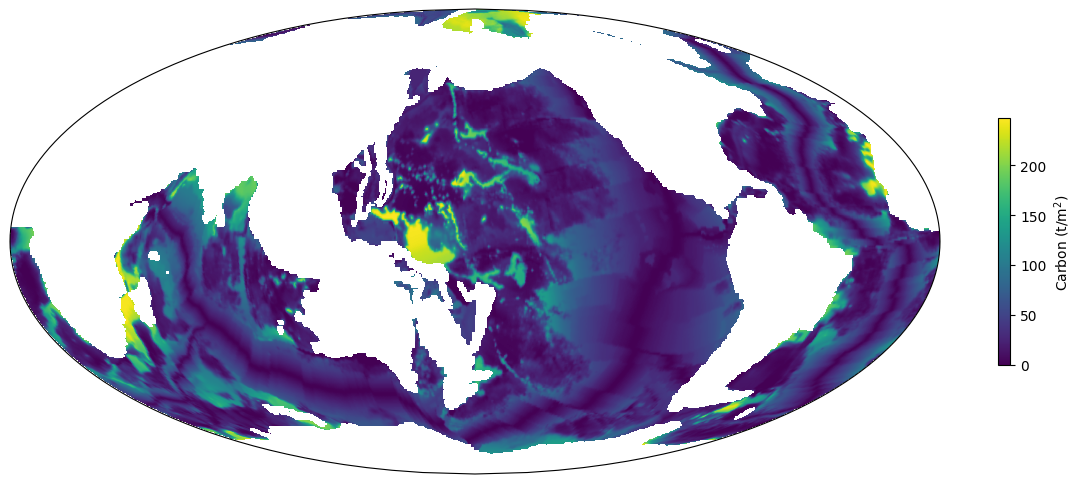

In [14]:
carbon_sediments_mean = read_netcdf_grid(carbon_sediments_filename.format("mean", 0))

proj = ccrs.Mollweide(180)

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=proj)
im = ax.imshow(carbon_sediments_mean*1e6, extent=extent_globe, origin='lower', transform=ccrs.PlateCarree())
fig.colorbar(im, shrink=0.4, label='Carbon (t/m$^2$)')

## Carbon in the crust

> __Citation:__
> Müller, R. D., & Dutkiewicz, A. (2018). Oceanic crustal carbon cycle drives 26-million-year atmospheric carbon dioxide periodicities. Science Advances, 4(2), 1–7. https://doi.org/10.1126/sciadv.aaq0500

Gillis and Coogan (2011) say that 66% of total CO2 is partitioned in the top 300 metres of the crust. Let's say that 100% is contained within 450 metres for now.


### Required inputs:
Carbon in the crust requires:

* **Crustal carbon grids**: these are **outputs of the notebook /utils/Min-Mean-Max-Crustal-Carbon.ipynb**, which  must be run prior to running this notebook.

In [15]:
# Path to input crustal carbon grids.
######## IF notebook /utils/Min-Mean-Max-Crustal-Carbon.ipynb WAS RUN, POINT TO THE OUTPUTS FROM THAT NOTEBOOK
crust_filename = grid_directory+"CrustalCarbon/{}/{}/upper_crustal_CO2_{}_{}.nc"
    
######## PATH TO SAVE CRUSTAL CARBON GRIDS TO. Do not change, only change parent_directory in cell 1. 
carbon_crust_filename = output_directory+"Reservoirs/Crust/{}/carbon_crust_grid_{:04d}.nc"

def reconstruct_crustal_carbon(reconstruction_time):
    # wt% CO2
    # Change the format strings to suit your crustal carbon directory
    CO2_min  = read_netcdf_grid(crust_filename.format("min",  reconstruction_time, "min", reconstruction_time), resample=(spacingX, spacingY))
    CO2_mean = read_netcdf_grid(crust_filename.format("mean", reconstruction_time, "mean", reconstruction_time), resample=(spacingX, spacingY))
    CO2_max  = read_netcdf_grid(crust_filename.format("max",  reconstruction_time, "max", reconstruction_time), resample=(spacingX, spacingY))
    
    CO2_crust_grid = np.ma.array([CO2_min, CO2_mean, CO2_max])
    
    # unit conversions
    CO2_grid = CO2_crust_grid/100*2900.0 # convert wt% to kg/m3 (multiply by density of basalt)
    CO2_grid *= 450.0 # integrate by 450m thickness the CO2 is contained within (now kg/m2)
    carbon_crust = CO2_grid * 12.0107/44.0095 # convert CO2 to carbon from ratio of molecular weight
    carbon_crust *= 1e-9 # convert kg/m2 to Mt/m2

    total_carbon_crust = np.nansum(carbon_crust*cell_area, axis=(1,2))

    if save_output_netcdf:
        write_netcdf_grid(carbon_crust_filename.format("min",  reconstruction_time), carbon_crust[0])
        write_netcdf_grid(carbon_crust_filename.format("mean", reconstruction_time), carbon_crust[1])
        write_netcdf_grid(carbon_crust_filename.format("max",  reconstruction_time), carbon_crust[2])
        
    return total_carbon_crust

In [16]:
total_carbon_crust = Parallel(n_jobs=-3, verbose=1)(
    delayed(reconstruct_crustal_carbon)(t) for t in reconstruction_times)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
/Users/lila0720/micromamba/envs/env_gplately/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-3)]: Done 184 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-3)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-3)]: Done 784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-3)]: Done 1001 out of 1001 | elapsed:  3.7min finished


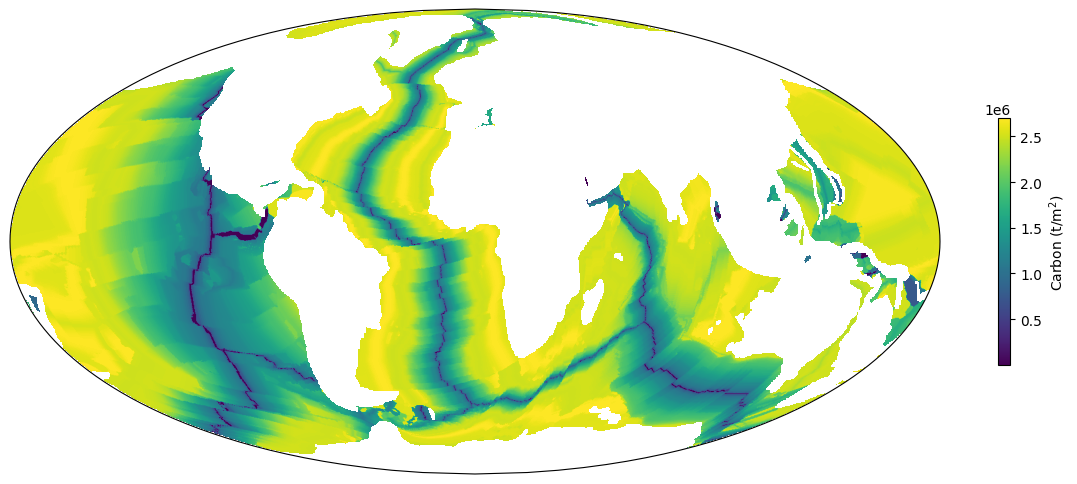

In [17]:
# Change the format strings to suit your crustal carbon directory
carbon_crust_mean = read_netcdf_grid(crust_filename.format("mean", 0, "mean", 0))

proj = ccrs.Mollweide()

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=proj)
im = ax.imshow(carbon_crust_mean*1e6, extent=extent_globe, origin='lower', transform=ccrs.PlateCarree())
fig.colorbar(im, shrink=0.4, label='Carbon (t/m$^2$)')

## Carbon in organic sediments

> __Citation:__

The average porosity of marine uncompacted sediments is 66%. Therefore, the actual sediment is only 34% of the decompacted total sediment thickness (see pybacktrack paper by Muller et al, G3, 2018).

The total organic carbon content is given as the dry weight percent of sediment without water.

The thickness of pure organic carbon is on average 0.31%, at minimum 0% and at maximum 0.68% of the total organic carbon content. 


### Required inputs:
Carbon in organic sediments requires:

* an **input total sediment thickness grid per timestep** 

In [25]:
######## An input TOTAL sediment thickness grid
total_sediments_filename = grid_directory+"TotalSediment/sed_thick_0.1d_{:.1f}.nc"

# Past 170 ma, we use empty grids because carbonate sediments are assumed to not exist. This is essentially
# a continental mask at 171Ma onwards.
continental_mask_filename = grid_directory+"ContinentalMasks/continent_mask_{:.1f}.nc"


####### PATH TO SAVE SEDIMENT CARBON GRIDS TO. Do not change, only change parent_directory in cell 1. 
organic_carbon_sediments_filename = output_directory+"Reservoirs/Organic_Sediments/{}/carbon_organic_sediments_grid_{:04d}.nc"

def reconstruct_organic_sedimentary_carbon(reconstruction_time):
    
    """
    if reconstruction_time > 540:
        # Use continent masks for times >540Ma as we do not have total sediment thickness before 540
        seds_grid = read_netcdf_grid(continental_mask_filename.format(reconstruction_time), resample=(spacingX, spacingY))
        
    else:
        # decompacted sediment thickness (metres)
        seds_grid  = read_netcdf_grid(total_sediments_filename.format(reconstruction_time), resample=(spacingX, spacingY))
    """
    seds_grid  = read_netcdf_grid(total_sediments_filename.format(reconstruction_time), resample=(spacingX, spacingY))
    
    seds_grid = np.ma.array([seds_grid, seds_grid, seds_grid])
        
    # Obtain decompacted sediments as 34% of total sediment thickness
    seds_grid = seds_grid * 0.34
    
    # Pure organic carbon thickness  (m)
    seds_grid_min = seds_grid[0] * 0.
    seds_grid_mean = seds_grid[1] * 0.0031
    seds_grid_max = seds_grid[2] * 0.0068
    
    # Pure organic carbon thickness in m
    seds_grid = np.ma.array([seds_grid_min, seds_grid_mean, seds_grid_max])
    
    seds_grid *= 2710. # convert m to kg/m2 (multiply by density of coccolith ooze)
    # seds_grid *= 12.0/100.1 # CaCO3 to C kg/m2
    seds_grid *= 1e-9 # kg/m2 to Mt/m2
    
    total_carbon_sediments = np.nansum(seds_grid*cell_area, axis=(1,2))

    if save_output_netcdf:
        write_netcdf_grid(organic_carbon_sediments_filename.format("min" , reconstruction_time), seds_grid[0])
        write_netcdf_grid(organic_carbon_sediments_filename.format("mean", reconstruction_time), seds_grid[1])
        write_netcdf_grid(organic_carbon_sediments_filename.format("max" , reconstruction_time), seds_grid[2])

    
    return total_carbon_sediments

In [26]:
%env PYTHONWARNINGS=ignore::RuntimeWarning
        
total_carbon_organic_sediments = Parallel(n_jobs=-3, verbose=1)(
    delayed(reconstruct_organic_sedimentary_carbon)(t) for t in reconstruction_times)

env: PYTHONWARNINGS=ignore::RuntimeWarning


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-3)]: Done 184 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-3)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-3)]: Done 784 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-3)]: Done 1001 out of 1001 | elapsed:  5.7min finished


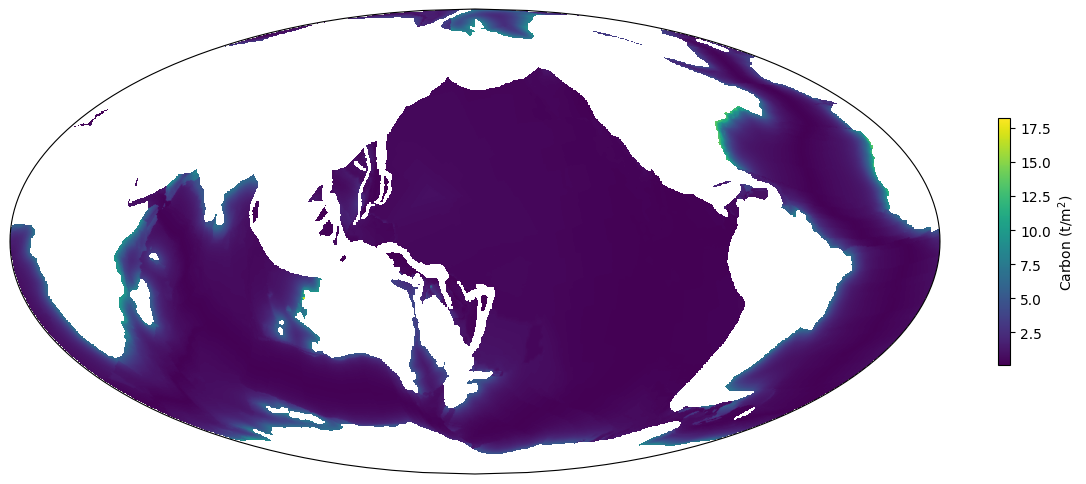

In [27]:
organic_carbon_sediments_mean = read_netcdf_grid(organic_carbon_sediments_filename.format("mean", 0))

proj = ccrs.Mollweide(180)

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=proj)
im = ax.imshow(organic_carbon_sediments_mean*1e6, extent=extent_globe, origin='lower', transform=ccrs.PlateCarree())
fig.colorbar(im, shrink=0.4, label='Carbon (t/m$^2$)')

## Total Carbon

A plot of all contributions to the global carbon budget

### Prepare a median filter for smoothing data
In this workflow, we use a median filter to smooth data points along the time dimension over a 10 Myr time window.

In [28]:
import scipy.ndimage as sn


# This works for smoothing arrays with a 3D, i.e. (4,1000,3) shape.
def median_filter_3d(array, time_window):
    smooth_result = np.zeros_like(array)
    for c in range(array.shape[0]):
        for i in range(3):
            smooth_result[c,:,i] = sn.median_filter(array[c,:,i], size=time_window)
            
    return smooth_result

# This works for smoothing arrays with a 2D, i.e. (1000,3) shape.
def median_filter_2d(array, time_window):
    smooth_result = np.zeros_like(array)
    for i in range(array.shape[-1]):
        smooth_result[:,i] = sn.median_filter(array[:,i], size=time_window)
    
    return smooth_result

In [29]:
time_window = 10
total_carbon_crust_smoothed = median_filter_2d(np.array(total_carbon_crust), time_window)
total_carbon_sediments_smoothed = median_filter_2d(np.array(total_carbon_sediments), time_window)
total_carbon_lithosphere_smoothed = median_filter_2d(np.array(total_carbon_lithosphere), time_window)
total_carbon_serpentinite_smoothed = median_filter_2d(np.array(total_carbon_serpentinite), time_window)
total_carbon_organic_sediments_smoothed = median_filter_2d(np.array(total_carbon_organic_sediments), time_window)

In [30]:
import pandas as pd

data_out = [total_carbon_crust_smoothed,
            total_carbon_lithosphere_smoothed,
            total_carbon_sediments_smoothed,
            total_carbon_serpentinite_smoothed,
            total_carbon_organic_sediments_smoothed]

total_carbon = np.array(data_out).sum(axis=0)
data_out.append(total_carbon)

headers = ['crust', 'lithosphere', 'sediments', 'serpentinite', 'organic_sediments', 'total']
quantiles = ['min', 'mean', 'max']

index = pd.MultiIndex.from_product([headers, quantiles])
carbon_df = pd.DataFrame(np.column_stack(data_out), columns = index, index=reconstruction_times) 
carbon_df.to_csv(output_directory+"/csv/01_in-plate_carbon.csv", index_label='time')

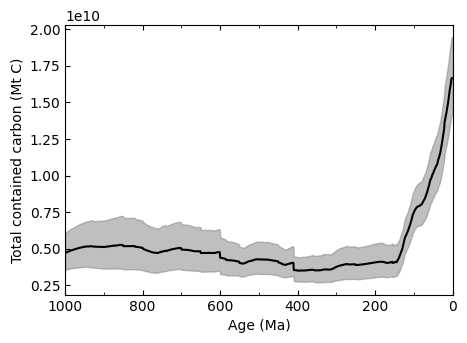

In [31]:
fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Total contained carbon (Mt C)', xlim=[max_time,0])
ax.fill_between(carbon_df.index, 
                carbon_df['total']['min'].to_numpy(),
                carbon_df['total']['max'].to_numpy(),
                color='0.5', alpha=0.5, label='Uncertainty')
ax.plot(reconstruction_times, carbon_df['total']['mean'].to_numpy(), 'k',   label='Mean')
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)

fig.savefig(output_directory+"/figures/total_contained_carbon.pdf", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/total_contained_carbon.svg", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/total_contained_carbon.png", bbox_inches='tight', dpi=300)

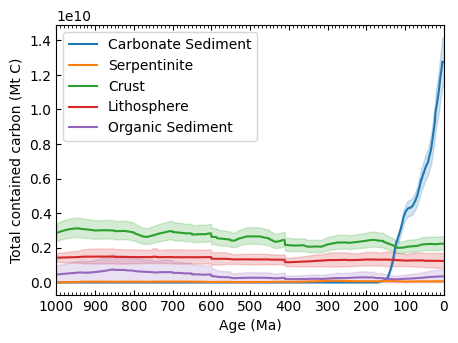

In [32]:
# compare each contribution
fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Total contained carbon (Mt C)', xlim=[max_time,0])
# ax.set_yscale('log')

i = 0
for label, carbon_contribution in [("Carbonate Sediment", total_carbon_sediments_smoothed),
                                   ("Serpentinite", total_carbon_serpentinite_smoothed),
                                   ("Crust", total_carbon_crust_smoothed),
                                   ("Lithosphere", total_carbon_lithosphere_smoothed),
                                   ("Organic Sediment", total_carbon_organic_sediments_smoothed)]:
    
    ax.fill_between(reconstruction_times,
                    sn.median_filter(carbon_contribution[:,0], time_window),
                    sn.median_filter(carbon_contribution[:,2], time_window),
                    color="C{}".format(i), alpha=0.2,)
    ax.plot(reconstruction_times, sn.median_filter(carbon_contribution[:,1], time_window), c='C{}'.format(i), label=label)
    i += 1


ax.legend()
ax.xaxis.set_minor_locator(MultipleLocator(100))

ax.xaxis.set_ticks(np.arange(0., 1001., 10.), minor=True)
ax.xaxis.set_ticks(np.arange(0., 1001., 100.), minor=False)

ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
fig.savefig(output_directory+"/figures/total_contained_carbon_comparison_sameaxes.pdf", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/total_contained_carbon_comparison_sameaxes.svg", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/total_contained_carbon_comparison_sameaxes.png", bbox_inches='tight', dpi=300)

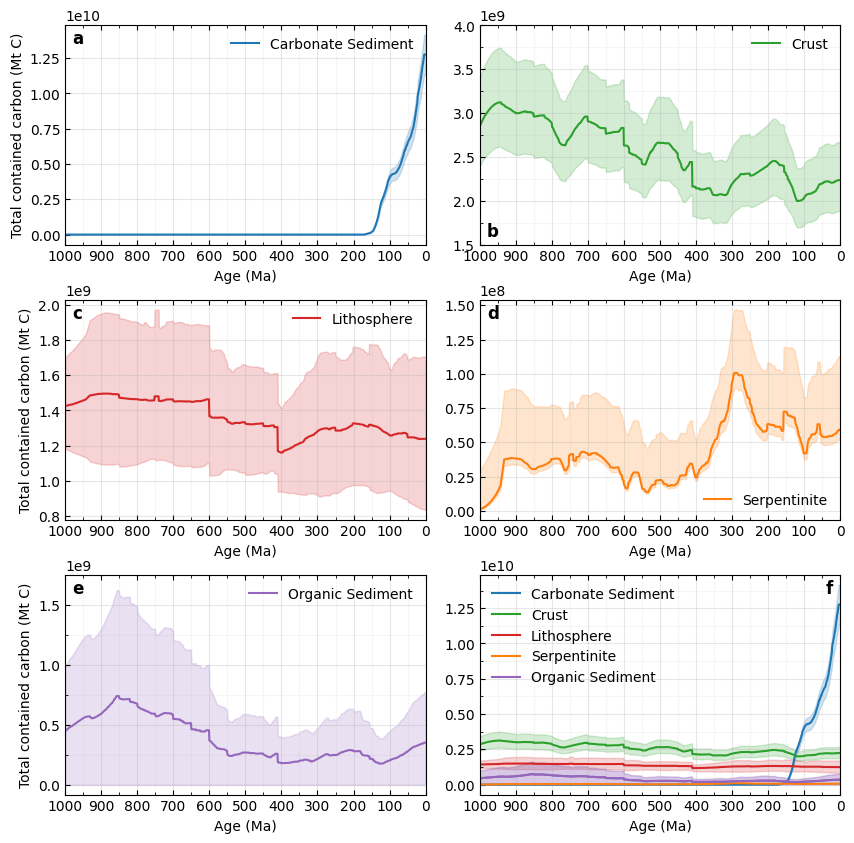

In [38]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(10,10))

i = 0
colours = ['C0', 'C2', 'C3', 'C1', 'C4', 'C4']
for ax, label, carbon_contribution in [(ax1, "Carbonate Sediment", total_carbon_sediments_smoothed),
                                       (ax2, "Crust", total_carbon_crust_smoothed),
                                       (ax3, "Lithosphere", total_carbon_lithosphere_smoothed),
                                       (ax4, "Serpentinite", total_carbon_serpentinite_smoothed),
                                      (ax5, "Organic Sediment", total_carbon_organic_sediments_smoothed),
                                      (ax6, "Organic Sediment", total_carbon_organic_sediments_smoothed)]:
    
    if ax == ax6:
        i = 0
        for label, carbon_contribution in [("Carbonate Sediment", total_carbon_sediments_smoothed),
                                       ("Crust", total_carbon_crust_smoothed),
                                       ("Lithosphere", total_carbon_lithosphere_smoothed),
                                       ("Serpentinite", total_carbon_serpentinite_smoothed),
                                      ("Organic Sediment", total_carbon_organic_sediments_smoothed)]:

            ax.fill_between(reconstruction_times,
                            sn.median_filter(carbon_contribution[:,0], time_window),
                            sn.median_filter(carbon_contribution[:,2], time_window),
                            color='{}'.format(colours[i]), alpha=0.2,)
            ax.plot(reconstruction_times, sn.median_filter(carbon_contribution[:,1], time_window), c='{}'.format(colours[i]), label=label)
            i += 1
        ax.set_xlabel('Age (Ma)')
        ax.legend(frameon=False)
        ax.set_xlim(max_time,0)
        ax.xaxis.set_minor_locator(MultipleLocator(100))
        ax.annotate('f', xy=(0.98, 0.98), xycoords='axes fraction', fontsize=12, fontweight="bold",
                horizontalalignment='right', verticalalignment='top')
        ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
        
        ax.xaxis.set_ticks(np.arange(0., 1001., 50.), minor=True)
        ax.xaxis.set_ticks(np.arange(0., 1001., 100.), minor=False)
        ax.yaxis.set_ticks(np.arange(0., 1.7e10, 0.125e10), minor=True)
        
        ax.grid(alpha=0.1, which='minor')
        ax.grid(alpha=0.3, which='major')

    
    ax.fill_between(reconstruction_times, 
                    sn.median_filter(carbon_contribution[:,0], time_window), 
                    sn.median_filter(carbon_contribution[:,2], time_window),
                    color="{}".format(colours[i]), alpha=0.2)
    
    ax.plot(reconstruction_times, 
            sn.median_filter(carbon_contribution[:,1], time_window), 
            c='{}'.format(colours[i]), label=label)
    i += 1
    
img_id = ["a","b","c","d","e","f"]
for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5]):
    
    if i == 1:
        ax.annotate('{}'.format(img_id[i]), xy=(0.02, 0.1), xycoords='axes fraction', fontsize=12, fontweight="bold",
                horizontalalignment='left', verticalalignment='top')
    else:
        ax.annotate('{}'.format(img_id[i]), xy=(0.02, 0.98), xycoords='axes fraction', fontsize=12, fontweight="bold",
                    horizontalalignment='left', verticalalignment='top')
    
    ax.set_xlabel('Age (Ma)')
    ax.set_ylabel('Total contained carbon (Mt C)')
    ax.legend(frameon=False)
    ax.set_xlim(max_time,0)
    ax.xaxis.set_minor_locator(MultipleLocator(100))
    ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
    
    ax.xaxis.set_ticks(np.arange(0., 1001., 50.), minor=True)
    ax.xaxis.set_ticks(np.arange(0., 1001., 100.), minor=False)
    
    if i == 4:
        ax.yaxis.set_ticks(np.arange(0., 2e9, 2.5e8), minor=True)
    if i == 1:
        ax.set_ylim([1.5e9, 4.01e9])
        ax.yaxis.set_ticks(np.arange(1.5e9, 4.01e9, 0.25e9), minor=True)

    if not i % 2 == 0:
        ax.set_ylabel(None)
        
    ax.grid(alpha=0.1, which='minor')
    ax.grid(alpha=0.3, which='major')

plt.subplots_adjust(hspace=0.25, wspace=0.15)
    

fig.savefig(output_directory+"/figures/total_contained_carbon_comparison.pdf", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/total_contained_carbon_comparison.svg", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/total_contained_carbon_comparison.png", bbox_inches='tight', dpi=300)